# Arloesiadur Research outputs

This notebook describes how we have produced the data inputs and findings for the Arloesiadur visualisations of research activity in Wales. For each of the visualisations, we process the data, export the clean dataset which was used to generate the visualisation, and provide summaries of findings based on our analysis.

This is a provisional notebook we plan to clean, refactor and document further in due course. Thank you for your patience

## Preamble

In [1]:
##Magics
%matplotlib inline


##Imports
#Utilities
import re
import itertools
from itertools import combinations
import pickle
import os
import json
import datetime

#Numerical and data
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
from scipy.spatial.distance import squareform, pdist

#Communities
import community


#Paths etc.
cwd = os.getcwd()

models_path = os.path.join(os.path.dirname(os.path.dirname(cwd)),'models')
ext_data = os.path.join(os.path.dirname(os.path.dirname(cwd)),'data/external')
int_data = os.path.join(os.path.dirname(os.path.dirname(cwd)),'data/interim')
proc_data = os.path.join(os.path.dirname(os.path.dirname(cwd)),'data/processed')
fig_path = os.path.join(os.path.dirname(os.path.dirname(cwd)),'reports/figures')

#Dates for tagging files
now= datetime.datetime.now()
today = "_".join([str(now.day),str(now.month),str(now.year)])

In [2]:
#Classes
class GtR_location_analysis():
    '''
    This class analyses the levels of activity in a topic community in an area.
    To do this, it allocates projects to topic communities based on their weights
    It then groups those by area and generates stats
    We need to decide whether the focus is on:
        #projects led by organisations in the area
        #projects involving organisations in the area
        #organisations in the area 
    
    '''
    
    def __init__(self,projects_df):
        '''
        Initialise the class with a project_df
        
        '''
        #Load the projects
        self.projects_df =  projects_df
        
        #Create a topic communities attribute with their labels (we can use it for subsetting)
        self.topic_comms = [x for x in self.projects_df.columns if x.split("_")[0]=='tc']
        
        #Create a topics_df attribute
        #self.topics_df = projects_df[self.topic_comms]
        
        #Create a metadata attribute (with relevant info for each org-project pair)
        self.meta_data_df = self.projects_df[list(set(self.projects_df.columns)-set(self.topic_comms))]
        
        #Create an org_geo coded df
        #self.org_geo_df = projects_df.drop_duplicates('org_id')[['org_id','nation','LAD13NM']].set_index('org_id')
        
        
        
    def classify_in_topics(self,how='max',**kwargs):
        '''
        Here, we convert the probabilities in the topic df into 1/0s for counting later. 
        We will have the following modalities:
            -max: Project is allocated to the topic where it has its maximum probability
            -thres: Any project with prob >thres (which could be zero) =1
            -top_x: Any project with topic in its top x has a 1 in that topic.
        
        '''
        
        #Create a df with topics to process
        topics = self.projects_df[self.topic_comms].copy()
        
        #We will input a kwargs dict with keys for the methods. We will need to tell the other methods
        #which ones to generate.
        #We put the outputs a an allocated_projects attribute which also includes the metadata.
        
        if how=='max':
            self.allocated_projects= pd.concat([self.meta_data_df,get_max_topics(topics)],axis=1)
            
        elif how=='thres':
            #This takes the keyword argument value
            
            self.allocated_projects = pd.concat([self.meta_data_df,get_thres_topics(topics,kwargs['param'])],axis=1)

            
        elif how=='top':
            self.allocated_projects = pd.concat([self.meta_data_df,get_top_topics(topics,kwargs['param'])],axis=1)
             
    
    def generate_area_stats(self,area='LAD13NM',unit='org',role='LEAD_ORG',stat='count',subset_years=None):
        '''
        This function generates project location stats. 
        If we give it the org unit parameter, it returns the stat of organisations working in an area.
        Otherwise, it returns the stat projects in the area. 
        The stat can be number of projects or total funding
        
        '''
        
        #Extract the allocated topics and metadata
        
        allocated_projects = self.allocated_projects.copy()
        topic_comms = self.topic_comms
        
        #metadata = self.meta_data_df.copy() 
        #geo_org = self.org_geo_df.copy()
        
        if subset_years != None:
            #Subset both dataframes by the start years (a list provided as input)
            #metadata = metadata.ix[[x in subset_years for x in metadata.start_year],:]
            #allocated_topics = allocated_topics.ix[metadata.index,:]
            allocated_projects = allocated_projects[[x in subset_years for x in allocated_projects.start_year]]
            
        #If we are looking at orgs, it's relatively simple:
        if unit  == 'org':
            
            #(i.e. is the organisation active in a topic cluster or not?)
            org_activity = allocated_projects.groupby(['org_id',area])[topic_comms].max().reset_index(drop=False)
            org_activity.drop('org_id',axis=1,inplace=True)
            
            #Group over the area and extract
            output = org_activity.groupby(area).sum()
                                
        if unit == 'proj':
            #Do we want to focus on projects led by organisations in the area, or projects involving organisations
            #in the area?
            
            if role=='LEAD_ORG':
                #Drop all non lead orgs
                allocated_projects = allocated_projects.ix[allocated_projects.role=='LEAD_ORG',:]
            else:
                #Drop all project duplicates in each LAD
                allocated_projects = allocated_projects.groupby(
                    area).apply(lambda x: x.drop_duplicates('project_id')).reset_index(drop=True)
        
            if stat == 'count':
                #Count number of projects with some activity in the area
                area_counts = allocated_projects.groupby(area)[topic_comms].sum()
                output = area_counts
                
            if stat == 'funding':
                #Extract budgets for projects in different topic clusters (NB if we have more than one
                    #label for cluster, there will be double counting.)
                funds = allocated_projects[topic_comms].apply(lambda x: x*allocated_projects['value_pounds'])
                
                funds[area] = allocated_projects[area]
                
                #Sum funds over locations
                area_funds = funds.groupby(area)[topic_comms].sum()
                
                output = area_funds
        
        #Relabel columns (remove tc_)
        output.columns = [x[3:] for x in output.columns]
        self.area_levels = output
        
        #Generate other stats
        #Shares of sector in area
        self.area_topic_shares = output.apply(lambda x: x/output.sum(axis=1),axis=0)
    
        #Extract LQs
        lq_df = get_lq(output).set_index(output.index.name)
        lq_df.fillna(value=0,inplace=True)
        self.area_topic_lq = lq_df.ix[:,:-1]
        
        #Share of area in sector in the UK
        self.area_share_in_topic =  output/output.sum()

In [3]:
#Functions: utilities
def get_lq(dist_df):
    """
    Function to produce location quotients based on a contingency table (e.g. geographical distribution of activity)
    Assumes that rows = observations (e.g. places) and columns = variables (e.g. industry, sector of activity)
    
    #Input:
    #A contingency table (output of pd.crosstab(unit,variable))
    #Returns a table with location quotients (and one variable with labels for plotting)
    """
    column_counts = dist_df.sum(axis=1).reset_index()
    
    props =  dist_df.apply(lambda x: x/dist_df.sum(axis=1))
    lqs = props.apply(lambda x: x/(dist_df.sum(axis=0)/dist_df.sum().sum()),axis=1).reset_index()
    
    lqs_w_counts = pd.merge(lqs,column_counts,on=lqs.columns[0])
    lqs_w_counts.rename(columns={0:"total_projects"},inplace=True)
    
    return(lqs_w_counts)


def out_function(csv,name,date,path=proc_data):
    csv.to_csv(path+'/{x}_{y}.csv'.format(x=date,y=name),index=True)
    
def extract_network_from_corpus(label_corpus,edge_attr="None",stop_words=None):
    """
    Extracts a network object from a list or series where every observation is a list of co-ocurring observations
    (e.g. interacting agents, or co-occurring words). 
    In the network output, the labels are nodes and co-occurrences between them are edges. 
    Weight is number of co-occurrences. There is the option to consider additional edge attributes.

    Inputs:
    label_corpus: corpus of documents with label co-occurrence or node interaction.
    edge_attr: an edge attribute associated to the interaction. It defaults to the string none (which we use
        for control flow)
    stop_words: labels to remove (e.g. generic terms)
    
    Returns a networkx object.
    
    """
    label_pairs_container =[]
    
    #!!! TODO Using type to control flow feels a bit hacky.
    if type(edge_attr) != str:
        #Container for pairs of labels
        edge_attr_name = edge_attr.name
    
    #For each pair
    for i in range(len(label_corpus)):
    
    #List of tuples where every tuple is a combination of topics
        pairs = list(combinations(label_corpus[i],2))
    
    #Extract these as lists of dicts capturing connections between topics, and add those to the container.
    #NB we are sorting the tuples to make sure that we don't duplicate edges.
        if len(pairs)>0:
            cont = [{'e1':sorted(tup)[0],'e2':sorted(tup)[1]} for tup in pairs]
            
            #Give each edge its corresponding attribute (if we have one)
            if type(edge_attr) != str:
                for d in cont:
                    d.update({edge_attr_name: edge_attr[i]})

            label_pairs_container.append(cont)

    #Flatten dict list and turn into DF
    label_pairs_df = pd.DataFrame([ds for sublist in label_pairs_container for ds in sublist])
    
    #Extract weights (depends on edge_attr)
    if type(edge_attr) != str:
        label_edgelist = pd.DataFrame(label_pairs_df.groupby(['e1','e2',edge_attr_name]
                                                        ).size()).reset_index().sort(columns=0,ascending=False)
    else:
        label_edgelist = pd.DataFrame(label_pairs_df.groupby(['e1','e2']
                                                        ).size()).reset_index().sort(columns=0,ascending=False)
    
    label_edgelist.rename(columns={0:'weight'},inplace=True)
    
    #Remove stop-words
    if stop_words != None:
        has_ttm =  [x in stop_words or y in stop_words for x,y in zip(label_edgelist['e1'],label_edgelist['e2'])]
        label_edgelist = label_edgelist[-pd.Series(has_ttm)]
    
    #Create label graph
    if type(edge_attr) != str:
        label_graph = nx.from_pandas_dataframe(label_edgelist,'e1','e2',['weight',edge_attr_name])
    else:
        label_graph = nx.from_pandas_dataframe(label_edgelist,'e1','e2',['weight'])
    
    return(label_graph)

In [3]:
#Analytical

#Functions used to get topics below
def get_max_topics(df):
    
    #This extracts one topic for each project and turns it into a df
    topic_top = pd.DataFrame([{x:1} for x in df.apply(lambda x: x.argmax(),axis=1)])
            
    #Fill the nas with zeroes
    topic_top.fillna(value=0,inplace=True)
    
    return(topic_top)

def get_thres_topics(df,value):
    #This creates a binary matrix where topics with prob>value = 1, else zero.
    topic_bin = df.applymap(lambda x: 1 if x>value else 0)
    
    return(topic_bin)
    
def get_top_topics(df,value):
    '''
    This creates a binary matrix where each project has a 1 in a topic if it scores above a certain threshold
    This also takes the keyword argument value
    Will this take ages?
    '''
    lead_topics = [df.iloc[row,:].sort_values(
        ascending=False).index[:value] for row in np.arange(0,len(df))]
            
    #Create a df using similar syntax as before
    topic_lead = pd.DataFrame([{x:1 for x in el} for el in lead_topics])
    topic_lead.fillna(value=0,inplace=True)
    return(topic_lead)   

def extract_heatmap(df,geo,var,area_name):
    '''
    A function to simplify the extraction of data from the GtR_location_analysis object.

    '''
    
    #Initialise object
    table_obj = GtR_location_analysis(df)
    
    #Classify in topics
    table_obj.classify_in_topics(how='top',**{'param':3})
    
    #Generate stats for analysis
    table_obj.generate_area_stats(unit='proj',area=geo,role='ANY',stat=var)
    
    output_1 = pd.DataFrame(table_obj.area_topic_lq.T.ix[:,area_name])
    output_2 = pd.DataFrame(table_obj.area_levels.T.ix[:,area_name])
    
    
    output_1['variable'] = var+'_lq'
    output_2['variable'] = var+'_total'
    
    
    return([output_1,output_2])

def create_lq_df(df):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    return(lqs)

def extract_bump_chart(df,geo,var,area_name,year_period):
    '''
    Similar function to above but also subsetting the data by the year.
    We use it to extract the dat
    '''
    
        
    #Initialise object
    table_obj = GtR_location_analysis(df)
    
    
    #Classify in topics
    table_obj.classify_in_topics(how='max')
    
    #Generate stats for analysis
    table_obj.generate_area_stats(unit='proj',area=geo,role='LEAD_ORG',stat=var,subset_years=year_period)
    
    output_1 = pd.DataFrame(table_obj.area_levels.T.ix[:,area_name])
    output_1['variable'] = var + '_total'
    output_1['year'] = "_".join([str(x) for x in year_period])
    
    #We need to fill nas for those cases where an area has disappeared from the data because it
    #has no activity
    output_1.fillna(value=0,inplace=True)
    
    #Also extract Location quotients
    output_2 = pd.DataFrame(table_obj.area_topic_lq.T.ix[:,area_name])
    output_2['variable'] = var + '_lq'
    output_2['year'] = "_".join([str(x) for x in year_period])
    
    #We need to fill nas for those cases where an area has disappeared from the data because it
    #has no activity
    output_2.fillna(value=0,inplace=True)
    
    return(pd.concat([output_1,output_2]))

def extract_bump_chart_aggregates(df,geo,var,area_name,year_period):
    '''
    Similar function to above but also subsetting the data by the year
    ''' 
        
    #Initialise object
    table_obj = GtR_location_analysis(df)
    
    #Classify in topics
    table_obj.classify_in_topics(how='max')
    
    #Generate stats for analysis
    table_obj.generate_area_stats(unit='proj',area=geo,role='LEAD_ORG',stat=var,subset_years=year_period)
    
    #This is a df with levels of activity by LAD and topic
    output_1 = pd.DataFrame(table_obj.area_levels.T)
    
    #Now rearrange this
    output_long = pd.melt(output_1.reset_index(drop=False),id_vars='index')
    
    #Create the discipline variable (to aggregate)
    output_long['discipline'] = [topic_comm_disc_lookup[x] for x in output_long['index']]
    
    #Aggregate by discipline
    output_aggregates = output_long.groupby(['discipline',geo])['value'].sum().reset_index(drop=False)
    
    #Pivot into a df with area rows and discipline columns
    output_wide = pd.pivot_table(output_aggregates,index=geo,columns='discipline',values='value')
    
    #These are our totals
    
    #Now extract the LQs
    output_wide_lq = create_lq_df(output_wide)
    
    #Extract selected_areas
    output_levels_area = pd.DataFrame(output_wide.T.ix[:,area_name])
    
    
    output_levels_area['variable'] = var + '_total'
    
    output_lqs_area = pd.DataFrame(output_wide_lq.T.ix[:,area_name])
    
    output_lqs_area['variable'] = var + '_lq'
    
    #Concatenate
    output_final = pd.concat([output_levels_area,output_lqs_area])
    
    #Add year and fill NAs
    output_final['year'] = "_".join([str(x) for x in year_period])
    output_final.fillna(value=0,inplace=True)
    output_final.set_index(['variable','year'],append=True,inplace=True)
    
    #return(output_final)
    
    return(output_final)
    

#Generate list of topics where an organisation is active
def get_active_topics(series):
    '''
    This function returns the research topics where an organisation has some activity
    '''
    some_act = list(series.index[series>0])
    return(some_act)

#Get top recommendations for an organisation
def get_top_topics_modified(series,value):
    '''
    This returns the names for the top 'value' organisations, ranked. It also returns their proximities
    '''
    
    #We set it up as a function to be applied.
    
    #Keep it simple
    
    series_sorted = series.sort_values(ascending=False)[:value]
    
    out = [(n,v) for n,v in zip(series_sorted.index,series_sorted)]
    return(out)


### 1. Load Data

In [4]:
projects = pd.read_csv(int_data+'/2017_5_17_projects_topics.csv')

with open(int_data+'/topic_comm_disc_lookup.p','rb') as infile:
    topic_comm_disc_lookup = pickle.load(infile)
    
#Load long lat
with open(ext_data+'/org_lat_lng_dict.p','rb') as infile:
    org_lat_lng_dict = pickle.load(infile)

In [37]:
projects_abstract_data = projects.dropna(axis=0,subset=['abstract_texts'])
projects_abstract_data['has_vr'] = [any(z in x.lower() for z in ['augmented reality','virtual reality',' vr ']) 
                      for x in projects_abstract_data.abstract_texts]

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [41]:
pd.crosstab(projects_abstract_data['has_vr'],projects_abstract_data['start_year'])
np.sum(projects_abstract_data.has_vr)

205

In [44]:
projects_abstract_data.groupby('has_vr')['value_pounds'].sum()

has_vr
False    65625331028
True        82119517
Name: value_pounds, dtype: int64

In [7]:
test = GtR_location_analysis(projects)

test.classify_in_topics(how='top',**{'param':3})

In [8]:
#Some data checks

#Check funding for projects led by Cardiff organisations

test_2 = GtR_location_analysis(projects)

test_2.classify_in_topics(how='max')


test_2.generate_area_stats(unit='proj',role='LEAD_ORG',stat='funding')



print(test_2.area_levels.ix['Cardiff',:].sort_values(ascending=False)[:5])


la_area = test_2.allocated_projects.ix[(test_2.allocated_projects.role=='LEAD_ORG')&
                                       (test_2.allocated_projects.LAD13NM=='Cardiff'),:]

la_proj_ams = la_area.ix[:,[x for x in la_area.columns if 'tc_' in x]]

la_fund_ams = la_proj_ams.apply(lambda x: x*la_area.value_pounds,axis=0).sum().sort_values(ascending=False)
print(la_fund_ams[:5])


systems_infrastructure         42761545.0
cells_cancer                   37376560.0
health_interventions_policy    31226359.0
psychiatry_mental_health       26265983.0
cellular_biology_cancer        15577172.0
Name: Cardiff, dtype: float64
tc_systems_infrastructure         42761545.0
tc_cells_cancer                   37376560.0
tc_health_interventions_policy    31226359.0
tc_psychiatry_mental_health       26265983.0
tc_cellular_biology_cancer        15577172.0
dtype: float64


In [9]:
#Check number of projects involving Cardiff organisations

test_3 = GtR_location_analysis(projects)

test_3.classify_in_topics(how='max')

test_3.generate_area_stats(unit='proj',role='ANY',stat='count')

print(test_3.area_levels.ix['Cardiff',:].sort_values(ascending=False)[:5])

print("\n")

la_area = test_3.allocated_projects.ix[test_3.allocated_projects.LAD13NM=='Cardiff',:].drop_duplicates('project_id')

print(la_area.ix[:,[x for x in la_area.columns if 'tc_' in x]].sum().sort_values(ascending=False)[:5])

print("\n")

print(la_area.role.value_counts())

print("\n")

print(len(test_3.allocated_projects.ix[(test_3.allocated_projects.LAD13NM=='Cardiff')&
                                       (test_3.allocated_projects.role=='LEAD_ORG'),:]))

print(test_3.area_topic_shares.ix['Cardiff',:].sort_values(ascending=False)[:5])

print("\n")

#la_shares = la_area.ix[:,[x for x in la_area.columns if 'tc_' in x]].sum()/len(la_area)
#print(la_shares.sort_values(ascending=False)[:5])

la_area.ix[:,[x for x in la_area.columns if 'tc_' in x]].sum().sort_values(ascending=False)[:5]/len(la_area)

systems_infrastructure         90.0
cells_cancer                   65.0
ageing                         56.0
health_interventions_policy    51.0
design_&_heritage              51.0
Name: Cardiff, dtype: float64


tc_systems_infrastructure         90.0
tc_cells_cancer                   65.0
tc_ageing                         56.0
tc_health_interventions_policy    51.0
tc_design_&_heritage              51.0
dtype: float64


LEAD_ORG      794
COLLAB_ORG    234
PP_ORG        103
COFUND_ORG     16
FELLOW_ORG     14
Name: role, dtype: int64


794
systems_infrastructure         0.077519
cells_cancer                   0.055986
ageing                         0.048234
health_interventions_policy    0.043928
design_&_heritage              0.043928
Name: Cardiff, dtype: float64




tc_systems_infrastructure         0.077519
tc_cells_cancer                   0.055986
tc_ageing                         0.048234
tc_health_interventions_policy    0.043928
tc_design_&_heritage              0.043928
dtype: float64

In [10]:
#Check analysis with top labels
test_4 = test_3 = GtR_location_analysis(projects)
test_4.classify_in_topics(how='top',**{'param':3})
test_4.generate_area_stats(unit='proj',role='LEAD_ORG',stat='count')

#Check top area shares for Cardiff
print(test_4.area_share_in_topic.ix['Cardiff',:].sort_values(ascending=False)[:5])

print("\n")

#Do the same thing by hand

la_test_4 = test_4.allocated_projects.ix[test_4.allocated_projects.role=='LEAD_ORG',:]

la_melted = pd.melt(la_test_4[['LAD13NM']+[x for x in la_test_4.columns if 'tc_' in x]],
                 id_vars='LAD13NM').reset_index(drop=False)

la_ct = pd.crosstab(la_melted.ix[la_melted.value>0,'LAD13NM'],la_melted.ix[la_melted.value>0,'variable'])
la_ct_s = la_ct / la_ct.sum()

print(la_ct_s.ix['Cardiff',:].sort_values(ascending=False)[:5])

#Now with 'any'

print("\n")
test_4.generate_area_stats(unit='proj',role='ANY',stat='count')
print(test_4.area_share_in_topic.ix['Cardiff',:].sort_values(ascending=False)[:5])

print("\n")


#Do the same thing by hand
#Everything continues checking

la_test_4 = test_4.allocated_projects.groupby('LAD13NM').apply(lambda x: x.drop_duplicates('project_id'))

la_melted = pd.melt(la_test_4[['LAD13NM']+[x for x in la_test_4.columns if 'tc_' in x]],
                 id_vars='LAD13NM').reset_index(drop=False)

la_ct = pd.crosstab(la_melted.ix[la_melted.value>0,'LAD13NM'],la_melted.ix[la_melted.value>0,'variable'])
la_ct_s = la_ct / la_ct.sum()

print(la_ct_s.ix['Cardiff',:].sort_values(ascending=False)[:5])

psychiatry_mental_health    0.041739
criminology_violence        0.038922
management                  0.035283
archaeology                 0.034582
sensors_data_telescopy      0.034000
Name: Cardiff, dtype: float64


variable
tc_psychiatry_mental_health    0.041739
tc_criminology_violence        0.038922
tc_management                  0.035283
tc_archaeology                 0.034582
tc_sensors_data_telescopy      0.034000
Name: Cardiff, dtype: float64


cosmology                   0.041809
psychiatry_mental_health    0.038302
astronomy                   0.037162
management                  0.036944
sensors_data_telescopy      0.036129
Name: Cardiff, dtype: float64


variable
tc_cosmology                   0.041809
tc_psychiatry_mental_health    0.038302
tc_astronomy                   0.037162
tc_management                  0.036944
tc_sensors_data_telescopy      0.036129
Name: Cardiff, dtype: float64


Everything checks

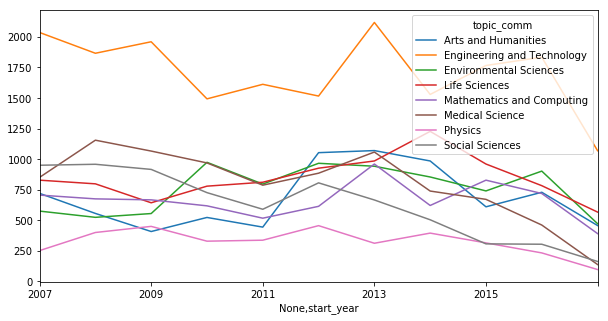

In [11]:
recent_projects = projects.ix[(projects.start_year>2006) & (projects.start_year<2018),:]

num_projs = pd.pivot_table(recent_projects.groupby(['start_year','topic_comm']).apply(lambda x: len(x)).reset_index(drop=False),
               index='topic_comm',columns='start_year').T

fig, ax = plt.subplots(figsize=(10,5))


num_projs.plot(ax=ax)
ax.set_xticklabels(np.arange(2007,2017,2))

In [12]:
projects.columns[:20]

Index(['Unnamed: 0', 'index', 'abstract_texts', 'topic_comm', 'funder_id',
       'funder_name', 'grant_cats', 'links', 'project_id', 'research_subjects',
       'research_topics', 'start', 'start_year', 'status', 'value_pounds',
       'role', 'org_id', 'org_id_short', 'name', 'id'],
      dtype='object')

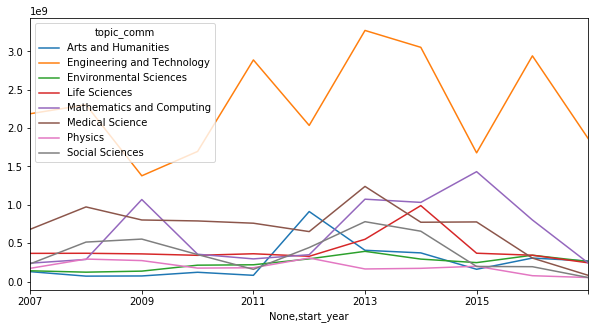

In [13]:
recent_projects = projects.ix[(projects.start_year>2006) & (projects.start_year<2018),:]

num_projs = pd.pivot_table(recent_projects.groupby(['start_year','topic_comm'])['value_pounds'].sum().reset_index(drop=False),
               index='topic_comm',columns='start_year').T

fig, ax = plt.subplots(figsize=(10,5))


num_projs.plot(ax=ax)
ax.set_xticklabels(np.arange(2007,2017,2))

## 2. Outputs


### Output 1: Heatmap

In [14]:
#Load Welsh LADS
lad_lu = pd.read_csv(ext_data+'/lad13_country_lu.csv')
welsh_lads = [x for x,y in zip(lad_lu.LAD13NM,lad_lu.CTRY13NM) if y =='Wales']

In [15]:
#Extract data using function extract_data_table_2.
#This one generates amounts raised in projects that have a discipline in its top 3.
nation_data = pd.concat([pd.concat(extract_heatmap(projects,'nation',var,'Wales')) 
                         for var in ['count','funding']],axis=0).set_index('variable',append=True)

welsh_lads_data = pd.concat([pd.concat(extract_heatmap(projects,'LAD13NM',var,welsh_lads)) 
                       for var in ['count','funding']],axis=0).set_index('variable',append=True)


#Join both
heatmap_data = nation_data.join(welsh_lads_data).reset_index(drop=False,level=1)

#Create the topic variable for the 'high level' discipline
heatmap_data.index.name='topic'
heatmap_data['discipline'] = [topic_comm_disc_lookup[x] for x in heatmap_data.index]

out_function(heatmap_data,'heatmap',date=today)

In [16]:
heatmap_data

,variable,Wales,Isle of Anglesey,Gwynedd,Conwy,Denbighshire,Flintshire,Wrexham,Powys,Ceredigion,...,Vale of Glamorgan,Rhondda Cynon Taf,Merthyr Tydfil,Caerphilly,Blaenau Gwent,Torfaen,Monmouthshire,Newport,Cardiff,discipline
topic,,,,,,,,,,,,,,,,,,,,,
ageing,count_lq,9.450007e-01,0.000000,1.915294e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.669490e+00,Medical Science
agriculture_plant_biology_entomology,count_lq,8.382026e-01,4.723666,1.269602e+00,0.000000,7.557866e-01,0.000000e+00,1.988912e+00,3.334353e+00,3.778933e+00,...,0.000000e+00,1.012214e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.574555e+00,0.000000e+00,3.580385e-01,Life Sciences
applications_devices_users,count_lq,1.130551e+00,0.000000,5.730363e-01,0.000000,5.799127e-01,1.380745e+00,7.630431e-01,1.705626e+00,6.731130e-01,...,0.000000e+00,2.588896e-01,7.248909e+00,3.451862e+00,0.000000e+00,1.610869e+00,0.000000e+00,2.788042e+00,6.368551e-01,Mathematics and Computing
archaeology,count_lq,1.254180e+00,0.000000,1.101007e+00,0.000000,5.571098e+00,0.000000e+00,7.330392e+00,0.000000e+00,3.481936e+00,...,0.000000e+00,4.974194e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.678412e+00,1.919414e+00,Arts and Humanities
architecture_spatial,count_lq,9.487997e-01,0.000000,2.913405e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.754980e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.058127e+00,Arts and Humanities
astronomy,count_lq,1.174283e+00,0.000000,0.000000e+00,0.000000,4.714730e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.052395e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.233507e+00,Physics
astrophysics,count_lq,1.085918e+00,0.000000,2.258824e-01,0.000000,2.285930e+00,0.000000e+00,3.007802e+00,0.000000e+00,1.224605e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.575145e+00,Physics
bio_informatics,count_lq,5.994004e-01,0.000000,1.214453e-01,0.000000,2.458054e+00,0.000000e+00,0.000000e+00,3.614785e+00,2.194691e+00,...,0.000000e+00,1.097345e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.557615e-01,Life Sciences
biopharmaceuticals,count_lq,3.986511e-01,0.000000,4.398762e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.589838e+00,...,0.000000e+00,1.987298e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.917118e-01,Life Sciences


### Output 2:  bump chart

In [17]:
#Table 3: Number of projects and levels of funding by LAD and year pairs

#These are the years we want to get data for
year_list = [[x,y] for x,y in zip(np.arange(2007,2016)[::2],np.arange(2008,2017)[::2])] 

In [24]:
#Extract results for wales years and variable
wales_results = [[extract_bump_chart(projects,geo='nation',var='count',area_name='Wales',year_period=x),
                  extract_bump_chart(projects,geo='nation',var='funding',area_name='Wales',year_period=x)] for x in
                 year_list]
                 
wales_results = pd.concat([x for el in wales_results for x in el],axis=0)
wales_results.set_index(['variable','year'],append=True,inplace=True)

wales_lad_results = [[extract_bump_chart(projects,geo='LAD13NM',var='count',area_name=welsh_lads,year_period=x),
                  extract_bump_chart(projects,geo='LAD13NM',var='funding',area_name=welsh_lads,year_period=x)] for x in
                 year_list]
                 
wales_lad_results = pd.concat([x for el in wales_lad_results for x in el],axis=0)
wales_lad_results.set_index(['variable','year'],append=True,inplace=True)

wales_results.index.rename('topic',level=0,inplace=True)
wales_lad_results.index.rename('topic',level=0,inplace=True)

bump_data = wales_results.join(wales_lad_results).reset_index(drop=False,level=[1,2])

bump_data['discipline'] = [topic_comm_disc_lookup[x] for x in bump_data.index]

#ARGH we also want the discipline totals and LQs.
#Need to extract them too.

#DO all the stuff above but with aggregate disciplines

#Extract results for wales years and variable
wales_results_agg = [[extract_bump_chart_aggregates(projects,geo='nation',var='count',area_name='Wales',year_period=x),
                  extract_bump_chart_aggregates(projects,geo='nation',var='funding',area_name='Wales',year_period=x)] for x in
                 year_list]
                 
wales_results_agg = pd.concat([x for el in wales_results_agg for x in el],axis=0)

#wales_results = pd.concat([x for el in wales_results for x in el],axis=0)
wales_lad_results_agg = [[extract_bump_chart_aggregates(projects,geo='LAD13NM',var='count',area_name=welsh_lads,year_period=x),
                  extract_bump_chart_aggregates(projects,geo='LAD13NM',var='funding',area_name=welsh_lads,year_period=x)] for x in
                 year_list]
                 
wales_lad_results_agg = pd.concat([x for el in wales_lad_results_agg for x in el],axis=0)

#Join the Wales and LAD results
bump_chart_data_agg = wales_results_agg.join(wales_lad_results_agg).reset_index(drop=False,level=[1,2])

#Some labelling as above
bump_chart_data_agg['discipline'] = [topic_comm_disc_lookup[x] if x in topic_comm_disc_lookup.keys() else x
                                  for x in bump_chart_data_agg.index]


#Combine the topic and discipline data
bump_chart_data = pd.concat([bump_data,bump_chart_data_agg]).reset_index(drop=False)
bump_chart_data.rename(columns={'index':'research_topic','variable':'metric'},inplace=True)

bump_chart_data= pd.melt(bump_chart_data,id_vars=['research_topic','metric','discipline','year'],var_name='location')

#Save
out_function(bump_chart_data,'bump_chart',date=today)

In [19]:
#Some bespoke analyses for the visualisation narratives and charts

bump_fund = pd.melt(bump_chart_data_agg,id_vars=['discipline','variable','year'],var_name='location')

bump_fund = bump_fund.ix[(bump_fund.variable=='funding_total') &
                         (bump_fund.location=='Wales'),
                               :].groupby(['discipline','year'])['value'].mean().reset_index(drop=False)

bump_fund_wide = pd.pivot_table(bump_fund,index='discipline',columns='year')


bump_fund_wide['growth'] = bump_fund_wide.iloc[:,-1]/bump_fund_wide.ix[:,0]
bump_stem = bump_fund_wide.ix[['Engineering and Technology','Mathematics and Computing','Medical Science','Physics'],:]

bump_stem.sum(axis=0)[0]


55554997.0

In [20]:
#Extract data for blog
digi_disciplines = ['security','robotics_cybernetics','prosthetics_robotics_health',
                    'statistics_data_analysis','bio_informatics']
bump_fund = bump_chart_data.ix[
    (bump_chart_data.metric=='funding_total') & 
    ([x in digi_disciplines for x in bump_chart_data.research_topic]) &
    (bump_chart_data.location=='Wales'),:].groupby(['research_topic','year'])['value'].mean().reset_index(drop=False)

bump_fund_wide = pd.pivot_table(bump_fund,index='research_topic',columns='year')

#bump_fund_wide.iloc[:,-1]

bump_fund_wide['growth'] = bump_fund_wide.iloc[:,-1]/bump_fund_wide.ix[:,0]
bump_fund_wide['value']['2015_2016'].sum()


4936608.0

In [21]:
projects.columns

Index(['Unnamed: 0', 'index', 'abstract_texts', 'topic_comm', 'funder_id',
       'funder_name', 'grant_cats', 'links', 'project_id', 'research_subjects',
       ...
       'tc_social_care', 'tc_social_history', 'tc_social_history_identity',
       'tc_sociology', 'tc_statistics_data_analysis', 'tc_surgert_cardiology',
       'tc_systems_infrastructure', 'tc_theoretical_physics',
       'tc_transport_communications', 'tc_visual'],
      dtype='object', length=113)

In [22]:
disc = 'tc_bio_informatics'

selections = projects.ix[(projects[disc]>0.2) &
                         (projects.is_wales==True) &
                         (projects.start_year>2014) &
                         (projects.role=='LEAD_ORG'),:]

for num in np.arange(len(selections)):
    print(num)
    
    proj = selections.iloc[num,:]
    
    
    print(proj['name'])
    print(proj['project_id'])
    print(proj['abstract_texts'])
    print(proj['value_pounds'])
    
    print('\n')
    

0
Aberystwyth University
http://gtr.rcuk.ac.uk:80/gtr/api/projects/DDFCEF02-04D4-469A-A258-5963E32ED661
Climate change accelerates the need for a smarter, more efficient, more secure agriculture. Because climate change is predicted to increase spatial and temporal variability, crop models able to predict the best local allele/phene combinations within a species, in addition to the best management systems (such as, for instance, species choice, rotations, sowing dates...) will be of great value for farmers and breeders worldwide. Aware of these issues and avenues, breeding companies now massively invest in crop and climate modelling.However, current crop models have large uncertainties, in particular under drought and high temperatures that often occur in combination and while their occurrences are likely to increase in several regions of the world. Whereas major environmental drivers of growth such as temperature, light and evaporative demand are now well captured in experiments, in pa

In [26]:
bump_fund = bump_chart_data.ix[
    (bump_chart_data.metric=='funding_lq') & 
    (bump_chart_data.discipline=='Mathematics and Computing'),:].groupby(['research_topic','year'])['value'].mean().reset_index(drop=False)

bump_fund_wide = pd.pivot_table(bump_fund,index='research_topic',columns='year')

#bump_fund_wide.iloc[:,-1]

bump_fund_wide['growth'] = bump_fund_wide.iloc[:,-1]/bump_fund_wide.ix[:,0]
bump_fund_wide

value                                          \
year                       2007_2008 2009_2010 2011_2012 2013_2014 2015_2016   
research_topic                                                                 
Mathematics and Computing   0.695094  0.185232  0.120949  0.094692  0.384835   
applications_devices_users  0.093432  0.235415  0.019005  0.137605  0.345661   
cognition_&_audio           0.000000  0.000000  0.000000  0.000000  0.000000   
computer_science            0.240733  0.026138  0.508562  0.000000  0.000000   
computer_vision             1.214025  0.882140  0.302092  0.258125  0.000000   
cyber_security              0.142304  0.000000  0.000000  0.107553  0.000000   
mathematics                 0.194186  0.278632  0.121452  0.085398  1.218342   
modelling_measurement       3.673709  0.094429  0.052904  0.171399  0.008118   
networks                    0.069594  0.195916  0.053003  0.018685  0.000000   
robotics_cybernetics        0.011579  0.000000  0.000000  0.000000  2.068397   
statistics_data_analysis    0.000000  0.000000  0.000000  0.129480  0.986532   
transport_communications    0.097253  0.000000  0.000000  0.000000  0.000000   

                                growth  
year                                    
research_topic                          
Mathematics and Computing     0.553645  
applications_devices_users    3.699593  
cognition_&_audio                  NaN  
computer_science              0.000000  
computer_vision               0.000000  
cyber_security                0.000000  
mathematics                   6.274083  
modelling_measurement         0.002210  
networks                      0.000000  
robotics_cybernetics        178.636609  
statistics_data_analysis           inf  
transport_communications      0.000000

### Output 3: Recommendation engine

**Tasks**

* Create organisational network. Label organisations based on their top discipline (specialisation based on the analysis above?) with different variables, as well as local authority.
* Measure distance between organisations based on specialisation.
* Identify, for each organisation, potential collaborators based on those who collaborate with other organisations similar to them.


In [27]:
#How do we create the network?
#Create a co-participation df with lists of Welsh organisations collaborating in projects
co_participation_df = projects.ix[
    [x in welsh_lads for x in projects.LAD13NM],:].groupby('project_id')['name'].apply(lambda x: list(x))


welsh_orgs = list(set([x for x,y in zip(projects.name,projects.LAD13NM) if y in welsh_lads]))

#Collaboration stats
pd.Series([len(x) for x in co_participation_df]).describe()

#Extract network
network = extract_network_from_corpus(co_participation_df)

#Add organisations with no connections
network.add_nodes_from([x for x in welsh_orgs if x not in network.nodes()])

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:75: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [28]:
#Now we want to add metadata to the network:
#What's the location of an organisation, in what topics does it specialise (in terms of projects and funding, 
#in how many projects is it involved?)

#We can use the GtR_location_analysis to do this (using name as the 'area' -it will count projects where the
#organisation participates, and funding.
#Initialise the analysis df
org_metadata = GtR_location_analysis(projects)

#Classify projects into topics based on their top 3
org_metadata.classify_in_topics('top',**{'param':3})

#Generate org stats
org_metadata.generate_area_stats(area='name',unit='proj',role='ANY',stat='count')

org_total_projects = org_metadata.area_levels

#Produce unique project count
org_project_count = projects.groupby('name')['project_id'].apply(lambda x: len(x.drop_duplicates()))

org_topics = org_metadata.area_levels.apply(lambda x: get_active_topics(x),axis=1)

In [29]:
#Now we want to convert the topics into disciplines.
#Use the topic discipline lookup on the melted dfs

#One liner
org_activity_long= pd.melt(org_total_projects.reset_index(drop=False),id_vars='name',
                                     value_name='total_projects')

#Allocate disciplines
org_activity_long['disc'] = [topic_comm_disc_lookup[x] for x in org_activity_long.variable]

#Group over disciplines
#Calculate top discipline (by project)
org_activity_discipline_top = pd.pivot_table(org_activity_long,index='name',columns='disc',values='total_projects',
                                         aggfunc='sum').idxmax(axis=1)

#Calculate any discipline the organisation works in
org_activity_discipline_any = pd.pivot_table(org_activity_long,index='name',columns='variable',values='total_projects',
                                         aggfunc='sum').apply(lambda x: list(x.index[x>0]),axis=1)

#Create dictionary lookup, also including project_count
org_disc_lookup = {x:[y,z,w] for x,y,z,w in zip(org_activity_discipline_top.index,list(org_activity_discipline_top),
                                           list(org_activity_discipline_any),
                                           list(org_project_count))}

#We also want to create a list for subsetting (capturing the disciplines an organisation is active in)

#Create lad lookup
org_lad_df =projects[['name','LAD13NM']].drop_duplicates('name')
org_lad_lookup = {x:y for x,y in zip(org_lad_df.name,org_lad_df.LAD13NM)}

In [30]:
#Give these characteristics to the nodes in the network

#Loop over nodes
for node in network.node:
    
    #Get top discipline
    network.node[node]['active_in_topic'] = ", ".join([x for x in org_disc_lookup[node][1]])
    
    #Get total projects
    network.node[node]['project_count'] = int(org_disc_lookup[node][2])
    
    #Get lon lat
    network.node[node]['lat'] = float(org_lat_lng_dict[node]['lat'])
    
    network.node[node]['lon'] = float(org_lat_lng_dict[node]['lon'])
    
    #Get lad
    network.node[node]['lad'] = org_lad_lookup[node]

nx.write_graphml(network,proc_data+'/welsh_collab_net.graphml')

In [31]:
#We have just created the collaboration network that exists. What about the opportunity network
#that could exist?

#We will create this in three steps:
#First, we create a similarity matrix between organisations based on their specialisation profile

#Create list of Welsh orgs
welsh_orgs = sorted(welsh_orgs)

#First we need their LQs
#Top 5 specialisations for each organisation
#Initialise the similarities object again.
org_metadata = GtR_location_analysis(projects)

#Classify projects into topics based on their top 5
org_metadata.classify_in_topics('top',**{'param':5})

#Generate organisational statistics
org_metadata.generate_area_stats(area='name',unit='proj',role='ANY',stat='count')
org_specs = org_metadata.area_topic_lq

#Add the index
org_specs.index = org_metadata.area_topic_lq.index

#Create cosine similarity matrix capturing similarities and differences between organisations
cos_org_sim =pd.DataFrame(squareform(1-pdist(np.array(org_specs.ix[welsh_orgs,:]),metric='cosine')),
                           index=welsh_orgs,columns=welsh_orgs)

cos_org_sim.to_csv(int_data+'/org_proximity_data_test.csv')


In [32]:
#Second, we get those organisations that are closer to each organisation
#Get 10 closest for each org
closest_org = cos_org_sim.apply(lambda x: get_top_topics_modified(x,10),axis=1)

In [33]:
#We want to get a bunch of recommendations for each organisation
#We will: 
#Extract all connections for the similar org with some activity in disciplines that our org is active on.
#Remove those that overlap.

#Create a container for results
cont = []

#Loop through the elements in the series of 'close' organisations##3
#for org_num in [245]:
for org_num in np.arange(len(closest_org)):

    #Get the organisation's name
    this_org =closest_org.index[org_num]
    
    #Get the organisation areas of activity
    this_org_discs = org_disc_lookup[this_org][1]
    
    #Get the organisation links
    this_org_links = list(network.edge[this_org].keys())
    
    #Get a list of closest organisations
    closest = closest_org[org_num]
    
    
    #Create a container of links including the organisation itself
    #this element to create the list later.
    links = []
    
    #For each 'close organisation', get its edges
    for el in closest:
        
        #A close organisation
        close_org = el[0]

        
        #The connections that the close organisation has
        connections = list(network.edge[close_org].keys())
        
        #print(connections)
        
        #Select those
        rel_connections = [x for x in connections if 
                           #conditions = there is an overlap in the disciplines where the orgs are active
                           (len(set(this_org_discs) & set(org_disc_lookup[x][1]))>0) 
                           #(this_org_discs==org_disc_lookup[x][0])
                           & (x not in this_org_links)
                           & (x != this_org)]
        
        #Each of these is a set of connections. The more times the same orgs appear in an element,
        #the stronger their link will be in the recommendation network
        
        if len(rel_connections)>0:
            links.append(rel_connections)

    cont.append([this_org,links]) 

In [34]:
#Create the network
prox_net = nx.Graph()

#Loop over the container to add edges.
for x in cont:
    #If we made any recommendations
    if len(x[1])>0:
        
        #Take all links
        all_links = [x for el in x[1] for x in el]
        
        #Count them
        all_links_counted = [[val,all_links.count(val)] for val in set(all_links)]
        
        #Select the top 5 links (this way we try to make sure we are not generating massive numbers of recommendations
        #for any given organisation)
        all_links_sorted = sorted(all_links_counted,key=lambda x:x[0],reverse=True)[:6]
        
        #Add edges (with weights)
        for l in all_links_sorted:
            prox_net.add_edge(x[0],l[0],weight=l[1])

In [35]:
recommendations = {}

for x in prox_net.node:
    #Extract neighbors
    neigh = prox_net.edges(x,data=True)
    
    #Sort them. If the list is longer than 10, generate top 10 recommendations
    neigh.sort(key = lambda x: x[2]['weight'],reverse=True)
    
    #Get top 10 partners
    partner_list = [x[1] for num,x in enumerate(neigh) if num<10]
    
    
    recommendations[x]= partner_list

In [36]:
#Add metadata to the nodes in the network.

#Loop over nodes
for node in prox_net.node:
    
    #Get top discipline
    prox_net.node[node]['top_discipline'] = org_disc_lookup[node][0]
    
    #Get total projects
    prox_net.node[node]['project_count'] = int(org_disc_lookup[node][2])
    
    #Get lad
    prox_net.node[node]['lad'] = org_lad_lookup[node]

nx.write_graphml(prox_net,proc_data+'/proximity_network.graphml')

In [37]:
#Add recommendations to the collaboration network

for node in network.node:
    try: 
        network.node[node]['recommendations'] = recommendations[node]
    except:
        network.node[node]['recommendations'] = 'none'

In [38]:
#Save

def network_saves(x,name):
    #Write network
    nx.write_edgelist(x,path=proc_data+'/{x}_{name}_edgelist.csv'.format(x=today,name=name),delimiter=',')

    #Collaborative nodes
    collab_nodes = pd.DataFrame(
    network.nodes(data=True),columns=['org','attributes']).to_csv(
        proc_data+'/{x}_{name}_node_attr.csv'.format(x=today,name=name),index=False)


[network_saves(net,name) for net,name in zip([network,prox_net],['collaboration','recommendation'])]

[None, None]

In [39]:
network_2 = network.copy()

for node in network_2.node:
    
    rec = network_2.node[node]['recommendations']
    
    if rec != 'none':
        network_2.node[node]['recommendations'] = ", ".join([x for x in rec])
    else:
        network_2.node[node]['recommendations'] = 'none'

    network_2.node[node]['lat_2'] = network_2.node[node]['lat']

nx.write_graphml(network_2,proc_data+'/{t}_revised_infogr8.graphml'.format(t=today))

In [40]:
#We want to create a node where there are no commas in the node names or recommendations 
network_no_commas = nx.relabel_nodes(network,{x:re.sub(",","",x) for x in network.node})

for i in network_no_commas.node:
    if network_no_commas.node[i]['recommendations']!='none':
        network_no_commas.node[i]['recommendations'] = [re.sub(",","",x) 
                                                    for x in 
                                                       network_no_commas.node[i]['recommendations']]

In [41]:
#Get all node metadata in a single dict

node_attr = network_no_commas.nodes(data=True)
node_attr_dict = {x[0]:x[1] for x in node_attr}

with open(proc_data+'/{t}_node_attr.json'.format(t=today),'w') as outfile:
    json.dump(node_attr,outfile)

#Extract network_df as a csv file
network_df = pd.DataFrame([{'n1':re.sub(",","",u),'n2':re.sub(",","",v),'weight':a['weight']} for u,v,a in network.edges(data=True)])
network_df.to_csv(proc_data+'/{t}_revised_edge_list.csv'.format(t=today),index=False)

In [42]:
#Determine how many connections are between organisations in the same local authority

same_loc = []

org_lad_lu_no_commas = {re.sub(",","",x):y for x,y in zip(org_lad_lookup.keys(),org_lad_lookup.values())}

for i in np.arange(0,len(network_df)):
    row = network_df.ix[i,:]
    same = True if org_lad_lu_no_commas[row['n1']]== org_lad_lu_no_commas[row['n2']] else False 
    same_loc.append(same)

np.sum(same_loc)/len(same_loc)

0.34888059701492535

In [43]:
#How many collaborations does an org have with others

def number_collabs(organisation):
    edges = network_df.ix[(network_df['n1']==organisation) | (network_df['n2']==organisation),:]
    tot = edges['weight'].sum()
    return([tot,edges])
    


In [44]:
cu = number_collabs('Cardiff University')

cu[0]-81

192

In [45]:
su = number_collabs('Swansea University')

su[0]-25

143

In [46]:
prox_net_df = pd.DataFrame([{'n1':re.sub(",","",u),'n2':re.sub(",","",v),'weight':a['weight']} for u,v,a in prox_net.edges(data=True)])

In [47]:
locs = []

for x in recommendations.keys():
    for y in recommendations[x]:
        #same = True if org_lad_lu_no_commas[row['n1']]== org_lad_lu_no_commas[row['n2']] else False 
        same = True if org_lad_lookup[x]== org_lad_lookup[y] else False 
        locs.append(same)

In [48]:
np.sum(locs)/len(locs)

0.14060803474484257

In [49]:
np.sum(network_df.weight)

950

In [50]:
# Some outputs for narratives and stories

#Some out
#Calculate collaborations in 2016 vs 2010

def extract_collaboration_year(df,lads,years):
    '''
    This function extracts the collaborations for a year
    
    '''
    #Get relevant years
    relevant_df = df.ix[[x in years for x in df.start_year],:]
    
    #Co-participation network
    co_participation_df = relevant_df.ix[
    [x in lads for x in relevant_df.LAD13NM],:].groupby('project_id')['name'].apply(lambda x: list(x))


    welsh_orgs = list(set([x for x,y in zip(relevant_df.name,relevant_df.LAD13NM) if y in welsh_lads]))

    #Collaboration stats
    #pd.Series([len(x) for x in co_participation_df]).describe()

    #Extract network
    network_y = extract_network_from_corpus(co_participation_df)

    #Add organisations with no connections
    #network.add_nodes_from([x for x in welsh_orgs if x not in network.nodes()])
    
    return([co_participation_df,network_y])



net_last_3 = extract_collaboration_year(projects,welsh_lads,[2014,2015,2016])
net_before_3 = extract_collaboration_year(projects,welsh_lads,[2011,2012,2013])

print(net_last_3[1].number_of_edges())
print(net_before_3[1].number_of_edges())

net_last_3[1].number_of_edges()/net_before_3[1].number_of_edges()

np.sum([len(x)>1 for x in net_last_3[0]])
np.sum([len(x)>1 for x in net_before_3[0]])

283
195


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:75: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


116

In [51]:
projects.ix[projects.LAD13NM=='Flintshire','name']

2210                     Merlin Circuits
2349                     Merlin Circuits
13671                             BIPVCo
16319            Deaf Access Cymru (DAC)
17190                       ConvaTec Ltd
20209           Topcon Great Britain Ltd
26369                    Merlin Circuits
32762                             BIPVCo
34510         Reynolds International Ltd
38105                       ConvaTec Ltd
41249                    Merlin Circuits
69631           Topcon Great Britain Ltd
72140                    Merlin Circuits
72181                    Merlin Circuits
73592                  Iceland Foods Ltd
73910                       ConvaTec Ltd
74461                  Iceland Foods Ltd
77322       National Eisteddfod of Wales
78118       National Eisteddfod of Wales
78209       National Eisteddfod of Wales
78228    Aerotech Design Consultants Ltd
Name: name, dtype: object